In [17]:
# Load the necessary libraries
import pandas as pd

In [19]:

## Import the files
# Source: https://www.ercot.com/mp/data-products/data-product-details?id=NP4-180-ER
# Define the file path template and years to load
file_path_template = "data/price/rpt.00013060.0000000000000000.DAMLZHBSPP_{}.xlsx"
years = range(2018, 2025)

# Initialize an empty list to store DataFrames
df_list = []

# Loop through the years, read the corresponding files, and append to the list
for year in years:
    file_path = file_path_template.format(year)
    
    df_year = pd.concat(pd.read_excel(file_path, sheet_name=None).values())

    df_list.append(df_year)

# Concatenate all DataFrames into a single DataFrame
df_price_all_years = pd.concat(df_list, ignore_index=True)

# Correct Hour Ending
df_price_all_years["hour"] = (df_price_all_years["Hour Ending"].str.slice(stop=2).astype(int)) - 1
df_price_all_years["datetime"] = pd.to_datetime(df_price_all_years["Delivery Date"] + " " + df_price_all_years.hour.astype(str) + ":00")
df_price_all_years = df_price_all_years.drop(columns=["hour","Hour Ending","Delivery Date"])

#Save as csv
df_price_all_years.to_csv("data/price/price_2018_2024.csv",index=False)

In [2]:
import datetime as dt
all_data = pd.concat([sheets_22,sheets_23,sheets_24])
all_data["Delivery Date"] = pd.to_datetime(all_data["Delivery Date"])
all_data

,Delivery Date,Hour Ending,Repeated Hour Flag,Settlement Point,Settlement Point Price
0,2022-01-01,01:00,N,HB_BUSAVG,32.72
1,2022-01-01,01:00,N,HB_HOUSTON,33.20
2,2022-01-01,01:00,N,HB_HUBAVG,32.69
3,2022-01-01,01:00,N,HB_NORTH,33.41
4,2022-01-01,01:00,N,HB_PAN,31.28
...,...,...,...,...,...
2155,2024-07-06,24:00,N,LZ_LCRA,19.64
2156,2024-07-06,24:00,N,LZ_NORTH,16.80
2157,2024-07-06,24:00,N,LZ_RAYBN,16.64
2158,2024-07-06,24:00,N,LZ_SOUTH,20.30


Text(0.5, 1.0, 'ERCOT Price Volatility 2022-2024')

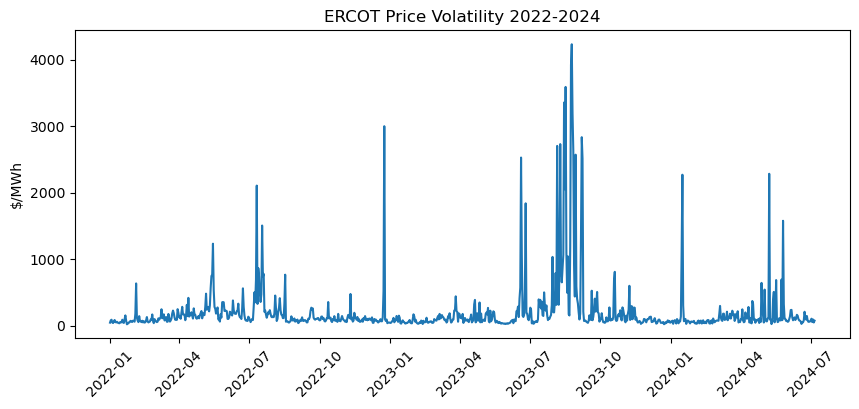

In [15]:
#Spread analysis
# Step 1: Group by 'Delivery Date'
grouped = all_data.groupby('Delivery Date')['Settlement Point Price']

# Step 2: Calculate the maximum and minimum price for each day
max_prices = grouped.max()
min_prices = grouped.min()

# Step 3: Calculate the intraday spread
intraday_spread = max_prices - min_prices

# Reset the index to get a DataFrame
df_spread = intraday_spread.reset_index()
df_spread.columns = ['date', 'spread']
df_spread['year'] = df_spread.date.dt.year


#plot the results
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.plot(df_spread.date,df_spread.spread)
plt.xticks(rotation=45)
plt.ylabel("$/MWh")
plt.title("ERCOT Price Volatility 2022-2024")


In [6]:
df_spread.groupby(['year'])["spread"].mean()
#72% increase between 2022 and 2023

year
2022    172.486630
2023    269.243534
2024    149.615000
Name: spread, dtype: float64

In [7]:
#By Hub Analysis
df_2023 = all_data[all_data['Delivery Date'].dt.year == 2023]
above_200 = df_2023[df_2023['Settlement Point Price'] > 200]
entry_count = above_200.groupby(["Settlement Point"])['Settlement Point Price'].count()
entry_count

Settlement Point
HB_BUSAVG     310
HB_HOUSTON    317
HB_HUBAVG     311
HB_NORTH      311
HB_PAN        307
HB_SOUTH      289
HB_WEST       316
LZ_AEN        351
LZ_CPS        329
LZ_HOUSTON    319
LZ_LCRA       333
LZ_NORTH      315
LZ_RAYBN      316
LZ_SOUTH      278
LZ_WEST       333
Name: Settlement Point Price, dtype: int64

In [8]:
# Group by 'Delivery Date' and 'Hour Ending' and calculate the mean settlement point price for each group
average_prices = all_data.groupby(['Delivery Date', 'Hour Ending'])['Settlement Point Price'].mean().reset_index()
average_prices

,Delivery Date,Hour Ending,Settlement Point Price
0,2022-01-01,01:00,32.828667
1,2022-01-01,02:00,24.710667
2,2022-01-01,03:00,22.357333
3,2022-01-01,04:00,17.516000
4,2022-01-01,05:00,11.044000
...,...,...,...
22024,2024-07-06,20:00,54.492000
22025,2024-07-06,21:00,41.774000
22026,2024-07-06,22:00,29.264667
22027,2024-07-06,23:00,22.362000


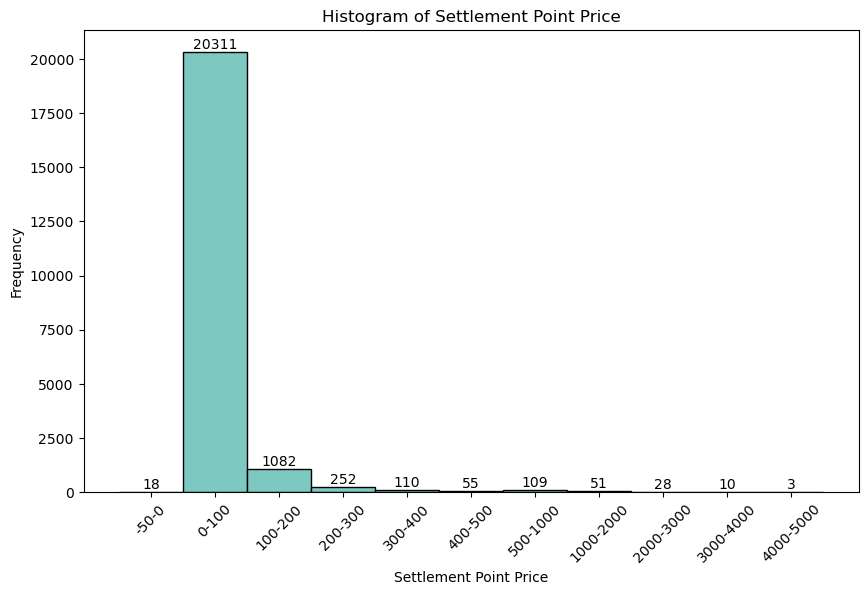

In [11]:
import numpy as np

# Create a histogram for the 'Settlement Point Price' column
bin_edges = [-50, 0, 100, 200, 300, 400, 500, 1000, 2000, 3000, 4000, 5000]

# Calculate the histogram manually
hist, _ = np.histogram(average_prices['Settlement Point Price'], bins=bin_edges)

# Create a bar plot with equally distributed bins on the x-axis
plt.figure(figsize=(10, 6))
num_bins = len(bin_edges) - 1
bin_centers = np.arange(num_bins)
bin_labels = [f'{bin_edges[i]}-{bin_edges[i+1]}' for i in range(num_bins)]
plt.bar(bin_centers, hist, width=1.0, color='#7DC9C2', edgecolor='black', align='center')
plt.title('Histogram of Settlement Point Price')
plt.xlabel('Settlement Point Price')
plt.ylabel('Frequency')
plt.grid(False)  # Remove grid lines

# Set x-ticks to show the actual bin edges
plt.xticks(bin_centers, bin_labels, rotation=45)

# Add data labels
for i in range(len(hist)):
    height = hist[i]
    if height > 0:  # Only label bins that have counts
        plt.text(bin_centers[i], height, str(int(height)), ha='center', va='bottom')

plt.show()

In [14]:
# Calculate the number of settlement price points above $200
count_above_200 = (average_prices['Settlement Point Price'] > 200).sum()

print(f"Number of settlement price points above $200: {count_above_200}")

Number of settlement price points above $200: 618


In [13]:
# Calculate the number of settlement price points above $50
count_above_50 = (average_prices['Settlement Point Price'] > 50).sum()

print(f"Number of settlement price points above $50: {count_above_50}")

Number of settlement price points above $50: 5676
